# 3c Lasso and Ridge Linear Regression with Cross-validation


## This notebook is identical in structure to 3b, the only difference being that this employs **_Polynomial Features_** 


#### This notebook has four main sections

## A. Imports, data shaping, and preprocessing
## B. Lasso CV regression on all features
## C. Lasso and Ridge regression on all features except `rating_count`
## D. Lasso and Ridge regression on all features except rating count but with also `budget` added as a feature

# A. Imports and data shaping

In [1]:
import pandas as pd
import numpy as np
import re
import math
import seaborn as sns

from matplotlib import pyplot as plt
from collections import defaultdict
#from IPython.core.display import display, HTML
import pickle
import copy
#from sklearn.preprocessing import OneHotEncoder
#from sklearn.model_selection import train_test_split
#display(HTML(my_html))     # make sure Jupyter knows to display it as HTML

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import  StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

In [2]:
#director = 'godard'
#director = 'hitchcock'
#director = 'bergman'
director = 'fassbinder'
#director = 'herzog'
#director = 'allen'
#director='herzog'

In [3]:

pd.options.display.float_format = "{:,.5f}".format

In [4]:

dir_str = director + '/'

films_filename = 'films_to_analyze_' + director +'.pickle'
with open(dir_str + films_filename, 'rb') as read_file:
    films_to_analyze = pickle.load(read_file)

In [5]:
films_to_analyze.head(100)

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,...,Christa Berndl,Anne-Marie Kuster,Heide Grübl,Andrea Grosske,Anna Karina,Macha Méril,Helen Vita,Heli Finkenzeller,Elke Aberle,Thomas Fengler
0,Querelle,"1,982.00000",8 September 1982 (France),108.00000,108.00000,"4,400,000.00000",NaN,NaN,NaN,6.80000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,Veronika Voss,"1,982.00000",13 May 1982 (Netherlands),104.00000,104.00000,"2,600,000.00000","8,144.00000","8,144.00000",NaN,7.80000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,Lola,"1,981.00000",4 August 1982 (USA),115.00000,115.00000,"3,500,000.00000","8,144.00000","8,144.00000",NaN,7.50000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,Theater in Trance,"1,981.00000",13 August 1984 (Denmark),91.00000,91.00000,"220,000.00000",NaN,NaN,NaN,7.10000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,Lili Marleen,"1,981.00000",14 January 1981 (West Germany),120.00000,120.00000,"10,500,000.00000","8,144.00000","8,144.00000",NaN,7.10000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
5,Berlin Alexanderplatz,"1,983.00000",10 August 1983 (USA),931.00000,931.00000,"13,000,000.00000",NaN,NaN,NaN,8.60000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
6,The Third Generation,"1,979.00000",9 September 1980 (USA),111.00000,NaN,"800,000.00000",NaN,NaN,NaN,6.90000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
7,The Marriage of Maria Braun,"1,979.00000",23 March 1979 (West Germany),120.00000,120.00000,"1,975,000.00000","9,061.00000","9,061.00000",NaN,7.80000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
8,In a Year with 13 Moons,"1,978.00000",11 June 1980 (USA),124.00000,124.00000,"700,000.00000",NaN,NaN,NaN,7.50000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
9,Despair,"1,978.00000",20 September 1978 (France),119.00000,119.00000,"6,000,000.00000","8,144.00000","8,144.00000",NaN,7.10000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [6]:
prevalent_actors_filename  = 'prevalent_actors_' + director +'.pickle'
with open(dir_str + prevalent_actors_filename, 'rb') as read_file:
    prevalent_actor_columns = pickle.load(read_file)

In [7]:
prevalent_actor_columns

Index(['Hanna Schygulla', 'Kurt Raab', 'Lilo Pempeit', 'Irm Hermann',
       'Margit Carstensen', 'Günther Kaufmann', 'Ulli Lommel', 'Ingrid Caven',
       'Karl Scheydt', 'Volker Spengler', 'Harry Baer', 'Hark Bohm',
       'Walter Sedlmayr', 'Gottfried John', 'Rudolf Waldemar Brem',
       'Katrin Schaake', 'Brigitte Mira', 'Klaus Löwitsch', 'Adrian Hoven',
       'El Hedi ben Salem', 'Peter Chatel', 'Peter Moland', 'Vitus Zeplichal',
       'Doris Mattes', 'Y Sa Lo', 'Elga Sorbas', 'Eva Mattes', 'Peter Kern',
       'Hans Hirschmüller', 'Marquard Bohm', 'Armin Meier', 'Wolfgang Schenck',
       'Elma Karlowa', 'Günter Lamprecht', 'Rudolf Lenz', 'Andrea Schober',
       'Hannes Gromball', 'Karlheinz Böhm', 'Roger Fritz', 'Ivan Desny',
       'Elisabeth Trissenaar', 'Margarethe von Trotta', 'Eddie Constantine',
       'Isolde Barth', 'Carla Egerer', 'Franz Maron', 'Claus Holm',
       'Barbara Sukowa', 'Christine Kaufmann', 'Herbert Steinmetz',
       'Karl-Heinz von Hassel', 'Sonja N

In [8]:
pickled_dict_of_actors_filename = 'dict_of_actors_' + director +'.pickle'
with open(dir_str + pickled_dict_of_actors_filename, 'rb') as read_file:
    dict_of_all_actors  = pickle.load(read_file) 

In [9]:
analysis_columns = ['title', 'year', 'duration', 'cinematographer', 'documentary', 'tv_series','rating', 'rating_count', *prevalent_actor_columns]

In [10]:
analysis_columns

['title',
 'year',
 'duration',
 'cinematographer',
 'documentary',
 'tv_series',
 'rating',
 'rating_count',
 'Hanna Schygulla',
 'Kurt Raab',
 'Lilo Pempeit',
 'Irm Hermann',
 'Margit Carstensen',
 'Günther Kaufmann',
 'Ulli Lommel',
 'Ingrid Caven',
 'Karl Scheydt',
 'Volker Spengler',
 'Harry Baer',
 'Hark Bohm',
 'Walter Sedlmayr',
 'Gottfried John',
 'Rudolf Waldemar Brem',
 'Katrin Schaake',
 'Brigitte Mira',
 'Klaus Löwitsch',
 'Adrian Hoven',
 'El Hedi ben Salem',
 'Peter Chatel',
 'Peter Moland',
 'Vitus Zeplichal',
 'Doris Mattes',
 'Y Sa Lo',
 'Elga Sorbas',
 'Eva Mattes',
 'Peter Kern',
 'Hans Hirschmüller',
 'Marquard Bohm',
 'Armin Meier',
 'Wolfgang Schenck',
 'Elma Karlowa',
 'Günter Lamprecht',
 'Rudolf Lenz',
 'Andrea Schober',
 'Hannes Gromball',
 'Karlheinz Böhm',
 'Roger Fritz',
 'Ivan Desny',
 'Elisabeth Trissenaar',
 'Margarethe von Trotta',
 'Eddie Constantine',
 'Isolde Barth',
 'Carla Egerer',
 'Franz Maron',
 'Claus Holm',
 'Barbara Sukowa',
 'Christine Kauf

## Dataset partitioned for analysis
except one-hot-encoding `cinematographer`

In [11]:
films_to_analyze.head()

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,...,Christa Berndl,Anne-Marie Kuster,Heide Grübl,Andrea Grosske,Anna Karina,Macha Méril,Helen Vita,Heli Finkenzeller,Elke Aberle,Thomas Fengler
0,Querelle,"1,982.00000",8 September 1982 (France),108.00000,108.00000,"4,400,000.00000",NaN,NaN,NaN,6.80000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,Veronika Voss,"1,982.00000",13 May 1982 (Netherlands),104.00000,104.00000,"2,600,000.00000","8,144.00000","8,144.00000",NaN,7.80000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,Lola,"1,981.00000",4 August 1982 (USA),115.00000,115.00000,"3,500,000.00000","8,144.00000","8,144.00000",NaN,7.50000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,Theater in Trance,"1,981.00000",13 August 1984 (Denmark),91.00000,91.00000,"220,000.00000",NaN,NaN,NaN,7.10000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,Lili Marleen,"1,981.00000",14 January 1981 (West Germany),120.00000,120.00000,"10,500,000.00000","8,144.00000","8,144.00000",NaN,7.10000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [12]:
films_and_features_to_analyze_df = films_to_analyze[analysis_columns]

In [13]:
films_and_features_to_analyze_df.head() 

,title,year,duration,cinematographer,documentary,tv_series,rating,rating_count,Hanna Schygulla,Kurt Raab,...,Carla Egerer,Franz Maron,Claus Holm,Barbara Sukowa,Christine Kaufmann,Herbert Steinmetz,Karl-Heinz von Hassel,Sonja Neudorfer,Alexander Allerson,Udo Kier
0,Querelle,"1,982.00000",108.00000,Xaver Schwarzenberger,0,0,6.80000,"5,824.00000",0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,Veronika Voss,"1,982.00000",104.00000,Xaver Schwarzenberger,0,0,7.80000,"6,238.00000",0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000
2,Lola,"1,981.00000",115.00000,Xaver Schwarzenberger,0,0,7.50000,"5,273.00000",0.00000,0.00000,...,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,1.00000,1.00000,0.00000,0.00000
3,Theater in Trance,"1,981.00000",91.00000,Werner Lüring,1,0,7.10000,97.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,Lili Marleen,"1,981.00000",120.00000,Xaver Schwarzenberger,0,0,7.10000,"3,571.00000",1.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000


In [14]:
cinematographer_include_threshold = films_and_features_to_analyze_df['cinematographer'].value_counts().min()
cinematographer_include_threshold

1

In [15]:
value_counts = films_and_features_to_analyze_df['cinematographer'].value_counts() # Specific column 
to_remove = value_counts[value_counts <= cinematographer_include_threshold].index
films_and_features_to_analyze_df['cinematographer'].replace(to_remove, 'OTHER', inplace=True)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/series.py:4479: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


### Regression analysis on `rating`,  `duration`, and `year` etc

#### `rating` as target

### Selecting columns for Train Test Split

In [16]:
films_and_features_to_analyze_df.columns # review columns we start with

Index(['title', 'year', 'duration', 'cinematographer', 'documentary',
       'tv_series', 'rating', 'rating_count', 'Hanna Schygulla', 'Kurt Raab',
       'Lilo Pempeit', 'Irm Hermann', 'Margit Carstensen', 'Günther Kaufmann',
       'Ulli Lommel', 'Ingrid Caven', 'Karl Scheydt', 'Volker Spengler',
       'Harry Baer', 'Hark Bohm', 'Walter Sedlmayr', 'Gottfried John',
       'Rudolf Waldemar Brem', 'Katrin Schaake', 'Brigitte Mira',
       'Klaus Löwitsch', 'Adrian Hoven', 'El Hedi ben Salem', 'Peter Chatel',
       'Peter Moland', 'Vitus Zeplichal', 'Doris Mattes', 'Y Sa Lo',
       'Elga Sorbas', 'Eva Mattes', 'Peter Kern', 'Hans Hirschmüller',
       'Marquard Bohm', 'Armin Meier', 'Wolfgang Schenck', 'Elma Karlowa',
       'Günter Lamprecht', 'Rudolf Lenz', 'Andrea Schober', 'Hannes Gromball',
       'Karlheinz Böhm', 'Roger Fritz', 'Ivan Desny', 'Elisabeth Trissenaar',
       'Margarethe von Trotta', 'Eddie Constantine', 'Isolde Barth',
       'Carla Egerer', 'Franz Maron', 'Claus

In [17]:
selected_cols = [*films_and_features_to_analyze_df.columns[1:6], *films_and_features_to_analyze_df.columns[7:]]

In [18]:
selected_cols

['year',
 'duration',
 'cinematographer',
 'documentary',
 'tv_series',
 'rating_count',
 'Hanna Schygulla',
 'Kurt Raab',
 'Lilo Pempeit',
 'Irm Hermann',
 'Margit Carstensen',
 'Günther Kaufmann',
 'Ulli Lommel',
 'Ingrid Caven',
 'Karl Scheydt',
 'Volker Spengler',
 'Harry Baer',
 'Hark Bohm',
 'Walter Sedlmayr',
 'Gottfried John',
 'Rudolf Waldemar Brem',
 'Katrin Schaake',
 'Brigitte Mira',
 'Klaus Löwitsch',
 'Adrian Hoven',
 'El Hedi ben Salem',
 'Peter Chatel',
 'Peter Moland',
 'Vitus Zeplichal',
 'Doris Mattes',
 'Y Sa Lo',
 'Elga Sorbas',
 'Eva Mattes',
 'Peter Kern',
 'Hans Hirschmüller',
 'Marquard Bohm',
 'Armin Meier',
 'Wolfgang Schenck',
 'Elma Karlowa',
 'Günter Lamprecht',
 'Rudolf Lenz',
 'Andrea Schober',
 'Hannes Gromball',
 'Karlheinz Böhm',
 'Roger Fritz',
 'Ivan Desny',
 'Elisabeth Trissenaar',
 'Margarethe von Trotta',
 'Eddie Constantine',
 'Isolde Barth',
 'Carla Egerer',
 'Franz Maron',
 'Claus Holm',
 'Barbara Sukowa',
 'Christine Kaufmann',
 'Herbert Stei

In [19]:
X= films_and_features_to_analyze_df[selected_cols]
y= films_and_features_to_analyze_df['rating']

In [20]:
y.isnull().values.any()

False

### Train-val vs. test split

In [21]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [22]:
X_test

,year,duration,cinematographer,documentary,tv_series,rating_count,Hanna Schygulla,Kurt Raab,Lilo Pempeit,Irm Hermann,...,Carla Egerer,Franz Maron,Claus Holm,Barbara Sukowa,Christine Kaufmann,Herbert Steinmetz,Karl-Heinz von Hassel,Sonja Neudorfer,Alexander Allerson,Udo Kier
34,"1,970.00000",90.00000,Dietrich Lohmann,0,1,498.00000,1.00000,1.00000,0.00000,0.00000,...,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
38,"1,970.00000",91.00000,Dietrich Lohmann,0,0,"1,208.00000",1.00000,0.00000,1.00000,0.00000,...,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,"1,981.00000",120.00000,Xaver Schwarzenberger,0,0,"3,571.00000",1.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000
13,"1,976.00000",86.00000,Michael Ballhaus,0,0,"3,687.00000",0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
31,"1,971.00000",95.00000,Michael Ballhaus,0,0,977.00000,1.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
27,"1,972.00000",87.00000,Dietrich Lohmann,0,1,209.00000,1.00000,1.00000,1.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
6,"1,979.00000",111.00000,Rainer Werner Fassbinder,0,0,"2,116.00000",1.00000,0.00000,1.00000,0.00000,...,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000
28,"1,972.00000",124.00000,Michael Ballhaus,0,0,"8,545.00000",1.00000,0.00000,0.00000,1.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


## Preprocessing

### Categorical Variable Preprocessing

#### One-hot-encoding

In [23]:
cat_ohe_vars = ['cinematographer']
X_train_val_cat_ohe = X_train_val[cat_ohe_vars]
#X_train_cat_ohe 

In [24]:
ohe = OneHotEncoder(sparse=False,  handle_unknown='ignore')
ohe.fit(X_train_val_cat_ohe)
cat_ohe = ohe.transform(X_train_val_cat_ohe)

In [25]:
columns=ohe.get_feature_names(cat_ohe_vars)
columns

array(['cinematographer_Dietrich Lohmann',
       'cinematographer_Jürgen Jürges',
       'cinematographer_Michael Ballhaus', 'cinematographer_OTHER',
       'cinematographer_Rainer Werner Fassbinder',
       'cinematographer_Xaver Schwarzenberger'], dtype=object)

In [26]:
X_train_val_cat_ohe_df = pd.DataFrame(cat_ohe, columns=columns, index=X_train_val_cat_ohe.index)
X_train_val_cat_ohe_df.head()

,cinematographer_Dietrich Lohmann,cinematographer_Jürgen Jürges,cinematographer_Michael Ballhaus,cinematographer_OTHER,cinematographer_Rainer Werner Fassbinder,cinematographer_Xaver Schwarzenberger
25,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000
15,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000
17,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000
8,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
16,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000


Repeating transformations on testing set

In [27]:
X_test_cat_ohe = X_test[['cinematographer']]
X_test_cat_ohe
cat_ohe_test = ohe.transform(X_test_cat_ohe)

cat_ohe_columns = ohe.get_feature_names(['cinematographer'])
X_test_cat_ohe_df = pd.DataFrame(cat_ohe_test, columns=cat_ohe_columns)


### Continuous Variable Preprocessing

In [28]:
cont_column_names = ['year', 'duration', 'rating_count']
X_train_val_cont = X_train_val[cont_column_names ]

X_test_cont      = X_test[     cont_column_names ]


X_train_val_cont.head()


,year,duration,rating_count
25,"1,972.00000",476.00000,354.00000
15,"1,976.00000",104.00000,"1,144.00000"
17,"1,975.00000",108.00000,"1,738.00000"
8,"1,978.00000",124.00000,"3,697.00000"
16,"1,975.00000",88.00000,"1,550.00000"


#### Generate log and polynomials

In [29]:
#X_train_val_cont_poly.head()

In [30]:
X_train_val_cont['log_year']         = np.log(X_train_val_cont.year)
X_train_val_cont['log_rating_count'] = np.log(X_train_val_cont.rating_count)


X_test_cont['log_year']         = np.log(X_test_cont.year)
X_test_cont['log_rating_count'] = np.log(X_test_cont.rating_count)

<ipython-input-30-d30627963e3a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_val_cont['log_year']         = np.log(X_train_val_cont.year)
<ipython-input-30-d30627963e3a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_val_cont['log_rating_count'] = np.log(X_train_val_cont.rating_count)
<ipython-input-30-d30627963e3a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [31]:
X_test_cont.shape[0]

8

#### Concatenate columns

In [32]:
cat_columns = ['documentary', 'tv_series', *prevalent_actor_columns]
X_train_val_cat_df = X_train_val[cat_columns]
#X_train_val_cat_df

X_test_cat_df = X_test[cat_columns]
#X_train_val_cat_df

In [33]:
X_test_cat_df.isnull().values.any()

False

In [34]:
X_train_val_combo= pd.concat([X_train_val_cont, X_train_val_cat_ohe_df, X_train_val_cat_df, ], axis='columns')
X_test_combo = pd.concat([X_test_cont.reset_index(drop=True), X_test_cat_ohe_df.reset_index(drop=True), X_test_cat_df.reset_index(drop=True), ], axis='columns')

In [35]:
X_test_cat_df.shape

(8, 56)

In [36]:
X_train_val_combo.isnull().values.any()

False

In [37]:
X_test_combo.isnull().values.any()

False

In [38]:
X_test_combo

,year,duration,rating_count,log_year,log_rating_count,cinematographer_Dietrich Lohmann,cinematographer_Jürgen Jürges,cinematographer_Michael Ballhaus,cinematographer_OTHER,cinematographer_Rainer Werner Fassbinder,...,Carla Egerer,Franz Maron,Claus Holm,Barbara Sukowa,Christine Kaufmann,Herbert Steinmetz,Karl-Heinz von Hassel,Sonja Neudorfer,Alexander Allerson,Udo Kier
0,"1,970.00000",90.00000,498.00000,7.58579,6.21060,1.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,"1,970.00000",91.00000,"1,208.00000",7.58579,7.09672,1.00000,0.00000,0.00000,0.00000,0.00000,...,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,"1,981.00000",120.00000,"3,571.00000",7.59136,8.18060,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000
3,"1,976.00000",86.00000,"3,687.00000",7.58883,8.21257,0.00000,0.00000,1.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
4,"1,971.00000",95.00000,977.00000,7.58630,6.88449,0.00000,0.00000,1.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
5,"1,972.00000",87.00000,209.00000,7.58680,5.34233,1.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
6,"1,979.00000",111.00000,"2,116.00000",7.59035,7.65728,0.00000,0.00000,0.00000,0.00000,1.00000,...,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000
7,"1,972.00000",124.00000,"8,545.00000",7.58680,9.05310,0.00000,0.00000,1.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [39]:
selected_columns = X_train_val_combo.columns
X_train_val_combo.columns

Index(['year', 'duration', 'rating_count', 'log_year', 'log_rating_count',
       'cinematographer_Dietrich Lohmann', 'cinematographer_Jürgen Jürges',
       'cinematographer_Michael Ballhaus', 'cinematographer_OTHER',
       'cinematographer_Rainer Werner Fassbinder',
       'cinematographer_Xaver Schwarzenberger', 'documentary', 'tv_series',
       'Hanna Schygulla', 'Kurt Raab', 'Lilo Pempeit', 'Irm Hermann',
       'Margit Carstensen', 'Günther Kaufmann', 'Ulli Lommel', 'Ingrid Caven',
       'Karl Scheydt', 'Volker Spengler', 'Harry Baer', 'Hark Bohm',
       'Walter Sedlmayr', 'Gottfried John', 'Rudolf Waldemar Brem',
       'Katrin Schaake', 'Brigitte Mira', 'Klaus Löwitsch', 'Adrian Hoven',
       'El Hedi ben Salem', 'Peter Chatel', 'Peter Moland', 'Vitus Zeplichal',
       'Doris Mattes', 'Y Sa Lo', 'Elga Sorbas', 'Eva Mattes', 'Peter Kern',
       'Hans Hirschmüller', 'Marquard Bohm', 'Armin Meier', 'Wolfgang Schenck',
       'Elma Karlowa', 'Günter Lamprecht', 'Rudolf Lenz'

### Train vs. val split

In [40]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val_combo, y_train_val, test_size=.25, random_state=43)

In [41]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

#mae(y_test, test_set_pred)

### Lasso CV

In [42]:
X_train_val_combo.values

array([[1.972e+03, 4.760e+02, 3.540e+02, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.976e+03, 1.040e+02, 1.144e+03, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [1.975e+03, 1.080e+02, 1.738e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [1.976e+03, 1.120e+02, 1.741e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.972e+03, 8.800e+01, 4.262e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.969e+03, 8.800e+01, 2.739e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

## B. Lasso CV regression on all features

### Polynomial testing

In [43]:
X_train_val_combo_columns = X_train_val_combo.columns
poly = PolynomialFeatures(degree=2)
X_train_val_combo_poly =  poly.fit_transform(X_train_val_combo)
X_test_combo_poly = poly.transform(X_test_combo)
X_train_val_combo_poly_columns = poly.get_feature_names(X_train_val_combo_columns)



In [44]:
## Scale the data as before
std = StandardScaler()
std.fit(X_train_val_combo_poly)
## Scale the Predictors on both the train and test set
X_tr = std.transform(X_train_val_combo_poly)
X_te = std.transform(X_test_combo_poly)

In [45]:
X_train_val_combo_poly_columns[:29]

['1',
 'year',
 'duration',
 'rating_count',
 'log_year',
 'log_rating_count',
 'cinematographer_Dietrich Lohmann',
 'cinematographer_Jürgen Jürges',
 'cinematographer_Michael Ballhaus',
 'cinematographer_OTHER',
 'cinematographer_Rainer Werner Fassbinder',
 'cinematographer_Xaver Schwarzenberger',
 'documentary',
 'tv_series',
 'Hanna Schygulla',
 'Kurt Raab',
 'Lilo Pempeit',
 'Irm Hermann',
 'Margit Carstensen',
 'Günther Kaufmann',
 'Ulli Lommel',
 'Ingrid Caven',
 'Karl Scheydt',
 'Volker Spengler',
 'Harry Baer',
 'Hark Bohm',
 'Walter Sedlmayr',
 'Gottfried John',
 'Rudolf Waldemar Brem']

In [46]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,500)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train_val)

LassoCV(alphas=array([1.00000000e-02, 1.01862899e-02, 1.03760502e-02, 1.05693455e-02,
       1.07662418e-02, 1.09668060e-02, 1.11711065e-02, 1.13792129e-02,
       1.15911962e-02, 1.18071285e-02, 1.20270833e-02, 1.22511358e-02,
       1.24793621e-02, 1.27118400e-02, 1.29486487e-02, 1.31898690e-02,
       1.34355829e-02, 1.36858742e-02, 1.39408283e-02, 1.42005318e-02,
       1.44650734e-02, 1.47345431e-0...
       6.54080591e+01, 6.66265452e+01, 6.78677305e+01, 6.91320378e+01,
       7.04198979e+01, 7.17317494e+01, 7.30680395e+01, 7.44292233e+01,
       7.58157646e+01, 7.72281357e+01, 7.86668179e+01, 8.01323013e+01,
       8.16250851e+01, 8.31456781e+01, 8.46945981e+01, 8.62723729e+01,
       8.78795401e+01, 8.95166472e+01, 9.11842520e+01, 9.28829225e+01,
       9.46132376e+01, 9.63757866e+01, 9.81711702e+01, 1.00000000e+02]),
        cv=5)

In [47]:
# This is the best alpha value it found 
lasso_model.alpha_

0.12537079874409204

In [48]:
len(lasso_model.coef_)

2346

In [49]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
coefficients = list(zip(X_train_val_combo_poly_columns, lasso_model.coef_))
coefficients

[('1', 0.0),
 ('year', 0.0),
 ('duration', 0.0),
 ('rating_count', 0.0),
 ('log_year', 0.0),
 ('log_rating_count', 0.0),
 ('cinematographer_Dietrich Lohmann', -0.0),
 ('cinematographer_Jürgen Jürges', 0.0),
 ('cinematographer_Michael Ballhaus', -0.0),
 ('cinematographer_OTHER', -0.0),
 ('cinematographer_Rainer Werner Fassbinder', 0.0),
 ('cinematographer_Xaver Schwarzenberger', 0.0),
 ('documentary', -0.0),
 ('tv_series', 0.0),
 ('Hanna Schygulla', -0.0),
 ('Kurt Raab', 0.0),
 ('Lilo Pempeit', 0.0),
 ('Irm Hermann', 0.0),
 ('Margit Carstensen', 0.0),
 ('Günther Kaufmann', -0.0),
 ('Ulli Lommel', -0.06613405912281242),
 ('Ingrid Caven', 0.0),
 ('Karl Scheydt', 0.0),
 ('Volker Spengler', 0.0),
 ('Harry Baer', -0.0),
 ('Hark Bohm', 0.0),
 ('Walter Sedlmayr', 0.0),
 ('Gottfried John', 0.0),
 ('Rudolf Waldemar Brem', -0.0),
 ('Katrin Schaake', -0.0),
 ('Brigitte Mira', 0.0),
 ('Klaus Löwitsch', -0.0),
 ('Adrian Hoven', 0.0),
 ('El Hedi ben Salem', 0.0),
 ('Peter Chatel', 0.0),
 ('Peter Mola

In [50]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_te)

In [51]:
# Find the MAE and R^2 on the test set using this model
mean_absolute_error = mae(y_test, test_set_pred)
mean_absolute_error

0.5080189558471813

In [52]:
r2_score_ = r2_score(y_test, test_set_pred)
r2_score_ 

-0.4796407569089194

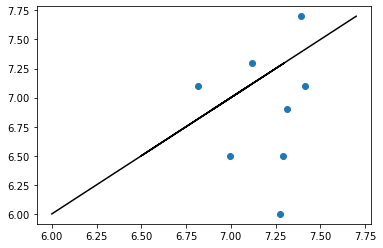

In [53]:
plt.scatter( test_set_pred, y_test)
plt.plot( y_test, y_test, c='k')

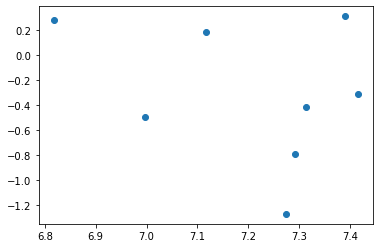

In [54]:
residual = y_test-test_set_pred
plt.scatter( test_set_pred, residual)

In [55]:
coefficients_df  = pd.DataFrame(coefficients, columns=['Feature', 'Coefficient'])

coefficients_df['abs_val_of_coefficient'] = coefficients_df.Coefficient.abs()
coefficients_df.sort_values(by='abs_val_of_coefficient', ascending=False, inplace=True)

coefficients_df.drop(columns='abs_val_of_coefficient', inplace=True)
coefficients_df.head(20)

,Feature,Coefficient
820,tv_series Gottfried John,0.10951
136,duration rating_count,0.08389
20,Ulli Lommel,-0.06613
407,cinematographer_Dietrich Lohmann Ulli Lommel,-0.05778
214,rating_count Lilo Pempeit,0.03496
867,Hanna Schygulla Ulli Lommel,-0.03493
874,Hanna Schygulla Gottfried John,0.02663
1360,Harry Baer Rudolf Waldemar Brem,-0.01686
282,log_year Ulli Lommel,-0.01349
160,duration Gottfried John,0.01275


In [56]:
Lasso_CV_model_w_rc = {"r2_score": r2_score, 'mean absolute error': mean_absolute_error, 'coefficients': coefficients_df}
Lasso_CV_model_w_rc 

{'r2_score': <function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 'mean absolute error': 0.5080189558471813,
 'coefficients':                                            Feature  Coefficient
 820                       tv_series Gottfried John      0.10951
 136                          duration rating_count      0.08389
 20                                     Ulli Lommel     -0.06613
 407   cinematographer_Dietrich Lohmann Ulli Lommel     -0.05778
 214                      rating_count Lilo Pempeit      0.03496
 ...                                            ...          ...
 785                   documentary Günter Lamprecht      0.00000
 786                        documentary Rudolf Lenz      0.00000
 787                     documentary Andrea Schober      0.00000
 788                    documentary Hannes Gromball      0.00000
 2345                                    Udo Kier^2     -0.00000
 
 [2346 rows x 2 columns]}

In [57]:
LCVM_w_rc_filename = 'Lasso_CV_model_w_rc_poly_' + director + '.pickle'
with open(dir_str + LCVM_w_rc_filename, 'wb') as to_write:
    pickle.dump(Lasso_CV_model_w_rc, to_write)

## C. Lasso and Ridge regression on all features except rating count

### Rerun the model without using `rating_count`

In [58]:
X_tr_no_rc = X_train_val_combo.drop(columns = ['rating_count', 'log_rating_count'])

In [59]:
X_te_no_rc = X_test_combo.drop(columns = ['rating_count', 'log_rating_count'])

In [60]:
#X_tr = pd.DataFrame(X_tr, columns=X_train.columns )
#X_tr.head()

In [61]:
#X_te = pd.DataFrame(X_te, columns=X_train.columns )

In [62]:
#X_tr_no_rc  = X_tr.drop(columns = ['rating_count', 'log_rating_count'])

In [63]:
#X_te_no_rc = X_te.drop(columns = ['rating_count', 'log_rating_count'])

In [64]:
X_tr_no_rc_columns = X_tr_no_rc.columns
poly = PolynomialFeatures(degree=2)

X_tr_no_rc_poly =  poly.fit_transform(X_tr_no_rc )
X_te_no_rc_poly = poly.transform(X_te_no_rc)

X_tr_no_rc_poly_columns = poly.get_feature_names(X_tr_no_rc_columns)

In [65]:
## Scale the data as before
std = StandardScaler()
std.fit(X_tr_no_rc_poly)
## Scale the Predictors on both the train and test set
X_tr_no_rc_poly_st = std.transform(X_tr_no_rc_poly)
X_te_no_rc_poly_st = std.transform(X_te_no_rc_poly)

In [66]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,1000)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr_no_rc_poly_st, y_train_val)

# This is the best alpha value it found 
lasso_model.alpha_

0.1775208011717635

In [67]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
coefficients = list(zip(X_tr_no_rc_poly_columns, lasso_model.coef_))
coefficients_df = pd.DataFrame(coefficients, columns=['Feature', 'Coefficient']).sort_values(by='Coefficient', ascending=False)



In [68]:
len(coefficients_df)
#lasso_model.coef_

2211

In [69]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_te_no_rc_poly_st)

In [70]:
# Find the MAE and R^2 on the test set using this model
mean_absolute_error = mae(y_test, test_set_pred)
mean_absolute_error

0.5115596518601851

In [71]:
r2_score_ = r2_score(y_test, test_set_pred)
r2_score_ 


-0.5933388434713689

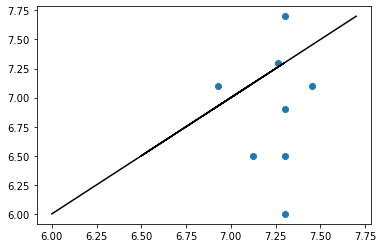

In [72]:
plt.scatter( test_set_pred, y_test)
plt.plot( y_test, y_test, c='k')
#plt.plot( x_te_no_rc, y_test, c='k')

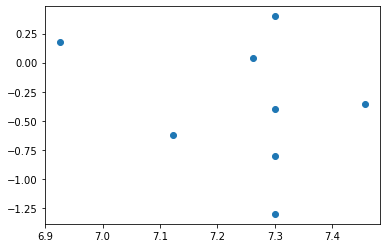

In [73]:
residual = y_test-test_set_pred
plt.scatter( test_set_pred, residual)



In [74]:
coefficients_df.head(30)

,Feature,Coefficient
154,duration Gottfried John,0.10334
739,Hanna Schygulla Gottfried John,0.02593
685,tv_series Gottfried John,0.02222
0,1,0.00000
1477,Brigitte Mira Doris Mattes,0.00000
1473,Brigitte Mira El Hedi ben Salem,0.00000
1474,Brigitte Mira Peter Chatel,-0.00000
1475,Brigitte Mira Peter Moland,0.00000
1476,Brigitte Mira Vitus Zeplichal,0.00000
1478,Brigitte Mira Y Sa Lo,-0.00000


In [75]:
Lasso_CV_model_no_rc = {"r2_score": r2_score, 'mean absolute error': mean_absolute_error, 'coefficients': coefficients_df}
Lasso_CV_model_no_rc 


{'r2_score': <function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 'mean absolute error': 0.5115596518601851,
 'coefficients':                                            Feature  Coefficient
 154                        duration Gottfried John      0.10334
 739                 Hanna Schygulla Gottfried John      0.02593
 685                       tv_series Gottfried John      0.02222
 0                                                1      0.00000
 1477                    Brigitte Mira Doris Mattes      0.00000
 ...                                            ...          ...
 1035                                 Ulli Lommel^2     -0.00072
 210                           log_year Ulli Lommel     -0.00629
 18                                     Ulli Lommel     -0.01008
 732                    Hanna Schygulla Ulli Lommel     -0.05132
 272   cinematographer_Dietrich Lohmann Ulli Lommel     -0.06578
 
 [2211 rows x 2 columns]}

In [76]:
LCVM_no_rc_filename = 'Lasso_CV_model_no_rc_poly_' + director
with open(dir_str + LCVM_no_rc_filename, 'wb') as to_write:
    pickle.dump(Lasso_CV_model_no_rc, to_write)

In [77]:
from sklearn.linear_model import lars_path
print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(np.array(X_tr_no_rc), y_train_val.values, method='lasso')

Computing regularization path using the LARS ...


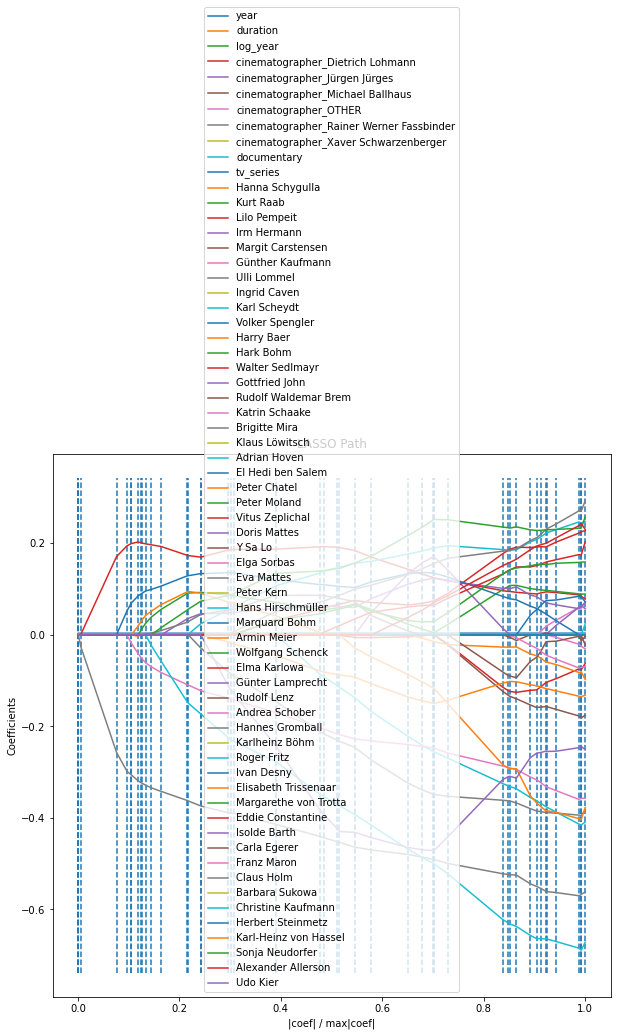

In [78]:
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X_tr_no_rc.columns)
plt.show()

### Ridge regression

In [79]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_tr_no_rc_poly_st, y_train_val)

# This is the best alpha value it found 
ridge_model.alpha_

100.0

In [80]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
coefficients = list(zip(X_tr_no_rc_poly_columns, ridge_model.coef_))

coefficients_df  = pd.DataFrame(coefficients, columns=['Feature', 'Coefficient'])

coefficients_df['abs_val_of_coefficient'] = coefficients_df.Coefficient.abs()
coefficients_df.sort_values(by='abs_val_of_coefficient', ascending=False, inplace=True)

coefficients_df.drop(columns='abs_val_of_coefficient', inplace=True)
coefficients_df

,Feature,Coefficient
724,tv_series Alexander Allerson,0.00802
1713,Vitus Zeplichal Alexander Allerson,0.00802
694,tv_series Vitus Zeplichal,0.00761
2080,Roger Fritz Isolde Barth,-0.00753
604,cinematographer_Xaver Schwarzenberger Isolde B...,-0.00753
...,...,...
1246,Harry Baer Andrea Schober,0.00000
305,cinematographer_Dietrich Lohmann Ivan Desny,0.00000
1249,Harry Baer Roger Fritz,0.00000
1250,Harry Baer Ivan Desny,0.00000


In [81]:
# Make predictions on the test set using the new model
test_set_pred = ridge_model.predict(X_te_no_rc_poly_st)

In [82]:
# Find the MAE and R^2 on the test set using this model
mean_absolute_error = mae(y_test, test_set_pred)
mean_absolute_error

0.44943185685066855

In [83]:
r2_score_ = r2_score(y_test, test_set_pred)
r2_score_ 


-0.2808796682863288

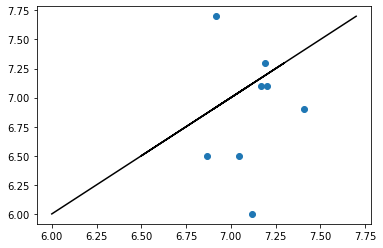

In [84]:
plt.scatter( test_set_pred, y_test)
plt.plot( y_test, y_test, c='k')

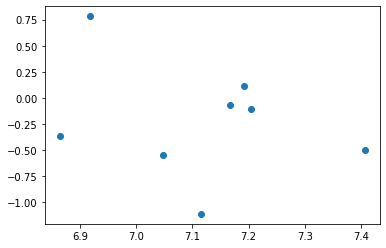

In [85]:
residual = y_test-test_set_pred
plt.scatter( test_set_pred, residual)


In [86]:
coefficients_df.head()

,Feature,Coefficient
724,tv_series Alexander Allerson,0.00802
1713,Vitus Zeplichal Alexander Allerson,0.00802
694,tv_series Vitus Zeplichal,0.00761
2080,Roger Fritz Isolde Barth,-0.00753
604,cinematographer_Xaver Schwarzenberger Isolde B...,-0.00753


In [87]:
Ridge_CV_model_no_rc = {"r2_score": r2_score, 'mean absolute error': mean_absolute_error, 'coefficients': coefficients_df}
Ridge_CV_model_no_rc 


{'r2_score': <function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 'mean absolute error': 0.44943185685066855,
 'coefficients':                                                 Feature  Coefficient
 724                        tv_series Alexander Allerson      0.00802
 1713                 Vitus Zeplichal Alexander Allerson      0.00802
 694                           tv_series Vitus Zeplichal      0.00761
 2080                           Roger Fritz Isolde Barth     -0.00753
 604   cinematographer_Xaver Schwarzenberger Isolde B...     -0.00753
 ...                                                 ...          ...
 1246                          Harry Baer Andrea Schober      0.00000
 305         cinematographer_Dietrich Lohmann Ivan Desny      0.00000
 1249                             Harry Baer Roger Fritz      0.00000
 1250                              Harry Baer Ivan Desny      0.00000
 0                                   

In [88]:
RCVM_no_rc_filename = 'Ridge_CV_model_no_rc_poly_' + director +'.pickle'
with open(dir_str + RCVM_no_rc_filename, 'wb') as to_write:
    pickle.dump(Ridge_CV_model_no_rc, to_write)

## D. Lasso and Ridge regression on all features except rating count but with also `budget` added as a feature

### Including `budget` as a feature 
This entails a fewer rows of data, since many of the films don't have budget info available on IMDB

In [89]:
films_to_analyze_financial_df = films_to_analyze[(films_to_analyze['budget'] > 0) & (films_to_analyze['worldwide_gross'] > 0)]

In [90]:
analysis_columns = ['title', 'year', 'duration', 'budget', 'cinematographer', 'documentary', 'tv_series','rating', *prevalent_actor_columns]

In [91]:
analysis_columns 

['title',
 'year',
 'duration',
 'budget',
 'cinematographer',
 'documentary',
 'tv_series',
 'rating',
 'Hanna Schygulla',
 'Kurt Raab',
 'Lilo Pempeit',
 'Irm Hermann',
 'Margit Carstensen',
 'Günther Kaufmann',
 'Ulli Lommel',
 'Ingrid Caven',
 'Karl Scheydt',
 'Volker Spengler',
 'Harry Baer',
 'Hark Bohm',
 'Walter Sedlmayr',
 'Gottfried John',
 'Rudolf Waldemar Brem',
 'Katrin Schaake',
 'Brigitte Mira',
 'Klaus Löwitsch',
 'Adrian Hoven',
 'El Hedi ben Salem',
 'Peter Chatel',
 'Peter Moland',
 'Vitus Zeplichal',
 'Doris Mattes',
 'Y Sa Lo',
 'Elga Sorbas',
 'Eva Mattes',
 'Peter Kern',
 'Hans Hirschmüller',
 'Marquard Bohm',
 'Armin Meier',
 'Wolfgang Schenck',
 'Elma Karlowa',
 'Günter Lamprecht',
 'Rudolf Lenz',
 'Andrea Schober',
 'Hannes Gromball',
 'Karlheinz Böhm',
 'Roger Fritz',
 'Ivan Desny',
 'Elisabeth Trissenaar',
 'Margarethe von Trotta',
 'Eddie Constantine',
 'Isolde Barth',
 'Carla Egerer',
 'Franz Maron',
 'Claus Holm',
 'Barbara Sukowa',
 'Christine Kaufmann',

In [92]:
films_and_features_to_analyze_df = films_to_analyze_financial_df[analysis_columns]

In [93]:
cinematographer_include_threshold = films_and_features_to_analyze_df['cinematographer'].value_counts().min()
cinematographer_include_threshold

3

In [94]:
value_counts = films_and_features_to_analyze_df['cinematographer'].value_counts() # Specific column 
to_remove = value_counts[value_counts <= cinematographer_include_threshold].index
films_and_features_to_analyze_df['cinematographer'].replace(to_remove, 'OTHER', inplace=True)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/series.py:4479: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


### Regression analysis on `rating`,  `duration`, `year` and `budget` etc

In [95]:
films_and_features_to_analyze_df.columns

Index(['title', 'year', 'duration', 'budget', 'cinematographer', 'documentary',
       'tv_series', 'rating', 'Hanna Schygulla', 'Kurt Raab', 'Lilo Pempeit',
       'Irm Hermann', 'Margit Carstensen', 'Günther Kaufmann', 'Ulli Lommel',
       'Ingrid Caven', 'Karl Scheydt', 'Volker Spengler', 'Harry Baer',
       'Hark Bohm', 'Walter Sedlmayr', 'Gottfried John',
       'Rudolf Waldemar Brem', 'Katrin Schaake', 'Brigitte Mira',
       'Klaus Löwitsch', 'Adrian Hoven', 'El Hedi ben Salem', 'Peter Chatel',
       'Peter Moland', 'Vitus Zeplichal', 'Doris Mattes', 'Y Sa Lo',
       'Elga Sorbas', 'Eva Mattes', 'Peter Kern', 'Hans Hirschmüller',
       'Marquard Bohm', 'Armin Meier', 'Wolfgang Schenck', 'Elma Karlowa',
       'Günter Lamprecht', 'Rudolf Lenz', 'Andrea Schober', 'Hannes Gromball',
       'Karlheinz Böhm', 'Roger Fritz', 'Ivan Desny', 'Elisabeth Trissenaar',
       'Margarethe von Trotta', 'Eddie Constantine', 'Isolde Barth',
       'Carla Egerer', 'Franz Maron', 'Claus Holm'

In [96]:
#selected_cols = [*films_and_features_to_analyze_df.columns[1:7], *films_and_features_to_analyze_df.columns[8:]]

In [97]:
selected_cols = films_and_features_to_analyze_df.columns[1:4]

In [98]:
X= films_and_features_to_analyze_df[selected_cols]
y= films_and_features_to_analyze_df['rating']

In [99]:
X

,year,duration,budget
1,"1,982.00000",104.00000,"2,600,000.00000"
2,"1,981.00000",115.00000,"3,500,000.00000"
4,"1,981.00000",120.00000,"10,500,000.00000"
7,"1,979.00000",120.00000,"1,975,000.00000"
9,"1,978.00000",119.00000,"6,000,000.00000"
11,"1,977.00000",201.00000,"1,800,000.00000"
13,"1,976.00000",86.00000,"1,100,000.00000"
14,"1,976.00000",112.00000,"600,000.00000"
16,"1,975.00000",88.00000,"375,000.00000"
17,"1,975.00000",108.00000,"750,000.00000"


In [100]:
y.isnull().values.any()

False

In [101]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [102]:
# X_train_val

## Preprocessing


### Categorical Variable Preprocessing

#### One-hot-encoding

### Continuous Variable Preprocessing

In [103]:
cont_column_names = ['year', 'duration', 'budget']
X_train_val_cont = X_train_val[cont_column_names ]

X_test_cont      = X_test[     cont_column_names ]


X_train_val_cont.head()

,year,duration,budget
11,"1,977.00000",201.00000,"1,800,000.00000"
20,"1,974.00000",135.00000,"750,000.00000"
7,"1,979.00000",120.00000,"1,975,000.00000"
38,"1,970.00000",91.00000,"180,000.00000"
30,"1,971.00000",103.00000,"1,100,000.00000"


In [104]:
X_train_val_cont['log_year']         = np.log(X_train_val_cont.year)
X_train_val_cont['log_budget']         = np.log(X_train_val_cont.budget)
#X_train_val_cont['budget_sq'] = X_train_val_cont.budget**2
#X_train_val_cont['budget_per_year'] = X_train_val_cont.budget/X_train_val_cont.year


X_test_cont['log_year']         = np.log(X_test_cont.year)
X_test_cont['log_budget']         = np.log(X_test_cont.budget)
#X_test_cont['budget_sq']  =  X_test_cont.budget**2
#X_test_cont['budget_per_year']  =   X_test_cont.budget/X_test_cont.year

In [105]:
X_test_cont.shape[0]

5

#### Concatenate columns

In [106]:
X_train_val_combo = X_train_val_cont

In [107]:
X_test_combo = X_test_cont

In [108]:
selected_columns = X_train_val_combo.columns
X_train_val_combo.columns

Index(['year', 'duration', 'budget', 'log_year', 'log_budget'], dtype='object')

### Train vs. val split



In [109]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val_combo, y_train_val, test_size=.25, random_state=43) #43

### Lasso CV

In [110]:
X_train_val_combo_columns = X_train_val_combo.columns
poly = PolynomialFeatures(degree=2)

X_train_val_combo_poly =  poly.fit_transform(X_train_val_combo)
X_test_combo_poly = poly.transform(X_test_combo)

X_train_val_combo_poly_columns = poly.get_feature_names(X_train_val_combo_columns)

In [111]:
## Scale the data as before
std = StandardScaler()
std.fit(X_train_val_combo_poly)
## Scale the Predictors on both the train and test set
X_tr = std.transform(X_train_val_combo_poly)
X_te = std.transform(X_test_combo_poly)

In [112]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,1000)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train_val)

LassoCV(alphas=array([1.00000000e-02, 1.00926219e-02, 1.01861017e-02, 1.02804473e-02,
       1.03756668e-02, 1.04717682e-02, 1.05687597e-02, 1.06666496e-02,
       1.07654461e-02, 1.08651577e-02, 1.09657929e-02, 1.10673602e-02,
       1.11698682e-02, 1.12733256e-02, 1.13777413e-02, 1.14831241e-02,
       1.15894830e-02, 1.16968270e-02, 1.18051653e-02, 1.19145070e-02,
       1.20248614e-02, 1.21362380e-0...
       8.08924349e+01, 8.16416760e+01, 8.23978568e+01, 8.31610415e+01,
       8.39312950e+01, 8.47086827e+01, 8.54932707e+01, 8.62851257e+01,
       8.70843150e+01, 8.78909065e+01, 8.87049689e+01, 8.95265713e+01,
       9.03557835e+01, 9.11926760e+01, 9.20373200e+01, 9.28897872e+01,
       9.37501502e+01, 9.46184819e+01, 9.54948564e+01, 9.63793480e+01,
       9.72720319e+01, 9.81729841e+01, 9.90822810e+01, 1.00000000e+02]),
        cv=5)

In [113]:
# This is the best alpha value it found 
lasso_model.alpha_

100.0

In [114]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
coefficients = list(zip(X_train_val_combo_poly_columns, lasso_model.coef_))
coefficients

[('1', 0.0),
 ('year', 0.0),
 ('duration', 0.0),
 ('budget', -0.0),
 ('log_year', 0.0),
 ('log_budget', 0.0),
 ('year^2', 0.0),
 ('year duration', 0.0),
 ('year budget', -0.0),
 ('year log_year', 0.0),
 ('year log_budget', 0.0),
 ('duration^2', 0.0),
 ('duration budget', 0.0),
 ('duration log_year', 0.0),
 ('duration log_budget', 0.0),
 ('budget^2', -0.0),
 ('budget log_year', -0.0),
 ('budget log_budget', -0.0),
 ('log_year^2', 0.0),
 ('log_year log_budget', 0.0),
 ('log_budget^2', 0.0)]

In [115]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_te)

In [116]:
# Find the MAE and R^2 on the test set using this model
mean_absolute_error = mae(y_test, test_set_pred)
mean_absolute_error

0.3549999999999997

In [117]:
r2_score_ = r2_score(y_test, test_set_pred)
r2_score_ 

-0.11160714285714235

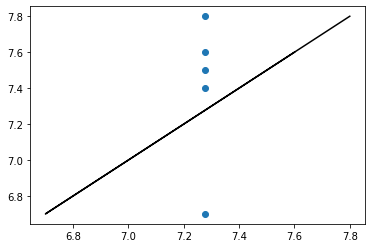

In [118]:
plt.scatter( test_set_pred, y_test)
plt.plot( y_test, y_test, c='k')

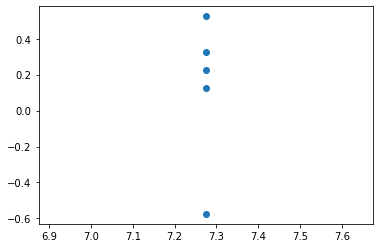

In [119]:
residual = y_test-test_set_pred
plt.scatter( test_set_pred, residual)

In [120]:
pd.options.display.float_format = "{:,.5f}".format



In [121]:
coefficients_df  = pd.DataFrame(coefficients, columns=['Feature', 'Coefficient'])
coefficients_df['abs_val_of_coefficient'] = coefficients_df.Coefficient.abs()
coefficients_df.sort_values(by='abs_val_of_coefficient', ascending=False, inplace=True)

coefficients_df.drop(columns='abs_val_of_coefficient', inplace=True)
coefficients_df.head(10)
#print(coefficients_df.head(10))

,Feature,Coefficient
0,1,0.00000
11,duration^2,0.00000
19,log_year log_budget,0.00000
18,log_year^2,0.00000
17,budget log_budget,-0.00000
16,budget log_year,-0.00000
15,budget^2,-0.00000
14,duration log_budget,0.00000
13,duration log_year,0.00000
12,duration budget,0.00000


In [122]:
Lasso_CV_model_w_budget = {"r2_score": r2_score, 'mean absolute error': mean_absolute_error, 'coefficients': coefficients_df}
Lasso_CV_model_w_budget 

{'r2_score': <function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 'mean absolute error': 0.3549999999999997,
 'coefficients':                 Feature  Coefficient
 0                     1      0.00000
 11           duration^2      0.00000
 19  log_year log_budget      0.00000
 18           log_year^2      0.00000
 17    budget log_budget     -0.00000
 16      budget log_year     -0.00000
 15             budget^2     -0.00000
 14  duration log_budget      0.00000
 13    duration log_year      0.00000
 12      duration budget      0.00000
 10      year log_budget      0.00000
 1                  year      0.00000
 9         year log_year      0.00000
 8           year budget     -0.00000
 7         year duration      0.00000
 6                year^2      0.00000
 5            log_budget      0.00000
 4              log_year      0.00000
 3                budget     -0.00000
 2              duration      0.00000
 20       

In [123]:
LCVM_w_budget_filename = 'Lasso_CV_model_w_budget_poly_' + director + '.pickle'
with open(dir_str + LCVM_w_budget_filename, 'wb') as to_write:
    pickle.dump(Lasso_CV_model_w_budget, to_write)

### Ridge regression

In [124]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_tr, y_train_val)

# This is the best alpha value it found 
ridge_model.alpha_

100.0

In [125]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
coefficients = list(zip(X_train_val_combo_poly_columns, ridge_model.coef_))


In [126]:
# Make predictions on the test set using the new model
test_set_pred = ridge_model.predict(X_te)

In [127]:
# Find the MAE and R^2 on the test set using this model
mean_absolute_error = mae(y_test, test_set_pred)
mean_absolute_error

0.3217414454168665

In [128]:
r2_score_ = r2_score(y_test, test_set_pred)
r2_score_ 

0.15733741415982938

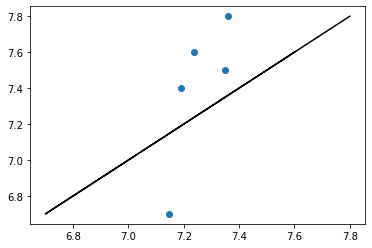

In [129]:

plt.scatter( test_set_pred, y_test)
plt.plot( y_test, y_test, c='k')

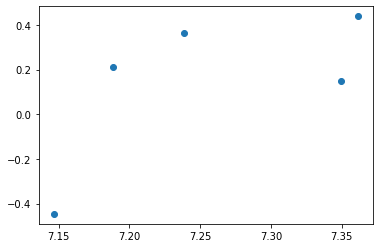

In [130]:
residual = y_test-test_set_pred
plt.scatter( test_set_pred, residual)

In [131]:
coefficients_df  = pd.DataFrame(coefficients, columns=['Feature', 'Coefficient'])
coefficients_df['abs_val_of_coefficient'] = coefficients_df.Coefficient.abs()
coefficients_df.sort_values(by='abs_val_of_coefficient', ascending=False, inplace=True)

coefficients_df.drop(columns='abs_val_of_coefficient', inplace=True)
coefficients_df.head(10)

,Feature,Coefficient
11,duration^2,0.02638
7,year duration,0.02434
13,duration log_year,0.02434
2,duration,0.02434
14,duration log_budget,0.02349
4,log_year,0.01122
18,log_year^2,0.01121
1,year,0.01119
9,year log_year,0.01119
6,year^2,0.01117


In [132]:
Ridge_CV_model_w_budget = {"r2_score": r2_score, 'mean absolute error': mean_absolute_error, 'coefficients': coefficients_df}
Ridge_CV_model_w_budget 

{'r2_score': <function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 'mean absolute error': 0.3217414454168665,
 'coefficients':                 Feature  Coefficient
 11           duration^2      0.02638
 7         year duration      0.02434
 13    duration log_year      0.02434
 2              duration      0.02434
 14  duration log_budget      0.02349
 4              log_year      0.01122
 18           log_year^2      0.01121
 1                  year      0.01119
 9         year log_year      0.01119
 6                year^2      0.01117
 15             budget^2     -0.00828
 17    budget log_budget     -0.00777
 8           year budget     -0.00758
 16      budget log_year     -0.00758
 3                budget     -0.00758
 10      year log_budget      0.00294
 19  log_year log_budget      0.00285
 5            log_budget      0.00284
 20         log_budget^2      0.00155
 12      duration budget      0.00045
 0        

In [133]:
RCVM_w_budget_filename = 'Ridge_CV_model_w_budget_poly_' + director +'.pickle'
with open(dir_str + RCVM_w_budget_filename, 'wb') as to_write:
    pickle.dump(Ridge_CV_model_w_budget, to_write)

In [134]:
report_filename = 'Lasso_CV_model_w_budget_poly_' + director +'.pickle'
with open(dir_str + report_filename, 'rb') as read_file:
    Lasso_CV_w_budget_poly_report = pickle.load(read_file)